## Classification


### Define Dataset

In [ ]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

train_data = MNIST('./data/train', train=True, download=True, transform=transforms.ToTensor())
test_data = MNIST('./data/test', train=False, download=True, transform=transforms.ToTensor())

### Define DataLoader

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False)

### Define model

In [ ]:
from torch import nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_layer = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_layer(x)
        return logits

model = Model()

### Define loss(criterion) & optimizer

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)
loss_function = nn.CrossEntropyLoss()

### Training & Testing

In [ ]:
model.train()
for x, y in train_dataloader:
    prediction = model(x)
    loss = loss_function(prediction, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
model.eval()
for x, y in test_dataloader:
    prediction = nn.Softmax(dim=1)(model(x))
    y_pred = prediction.argmax(1)
    print(f"Predicted class: {y_pred}, True label: {y}")

# 실습

## Exercise 1

In [1]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = CIFAR10("./data", train=True, download=True, transform=transform)
test_data = CIFAR10("./data", train=False, download=True, transform=transform)

print(len(train_data))
print(len(test_data))

/home/user/miniconda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified
Files already downloaded and verified
50000
10000


In [2]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=False)

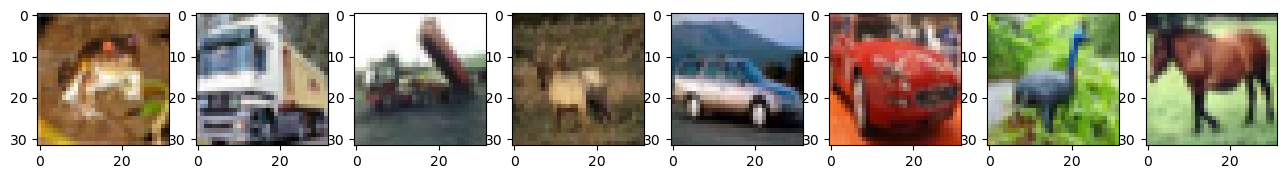

Labels: frog | truck | truck | deer | car | car | bird | horse | 

In [3]:
import matplotlib.pyplot as plt # library for plotting
from torchvision.transforms.functional import to_pil_image # function for changing tensor to pil image

# Visualize first 8 images
plt.figure(figsize=(16,4))
for i in range(8):
    img = to_pil_image(train_data[i][0]/2 + 0.5)
    plt.subplot(1,8,i+1)
    plt.imshow(img)
plt.show()

# Print labels for each image
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print("Labels: ", end='')
for i in range(8): print(classes[train_data[i][1]], end=' | ')

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.fc_layer = nn.Linear(16 * 8 * 8, 10)

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)

        x2 = torch.flatten(x2, 1)
        x3 = self.fc_layer(x2)
        out = F.softmax(x3, dim=1)
        return out


net = CNN()

In [23]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

다음은 생성한 모델을 cpu를 통해 학습할 것인가 gpu를 사용하여 학습할 것인가 결정하는 코드입니다.  
torch.cuda.is_available() 함수는 현재 환경에서 프로그램이 gpu를 사용할 수 있는가를 true/false로 반환해주게 됩니다.
기본적으로 모델과 데이터는 cpu에서 연산이 되게 됩니다. 따라서, gpu를 사용할 수 있는 환경이라면 torch.device('cuda')를 꼭 사용해주는 것이 좋습니다.  
이때, 모델을 gpu에 올리는 것과 동시에 train/test시 각 배치 단위의 데이터 역시 gpu에 올려야 정상적으로 연산이 진행될 수 있습니다.

In [24]:
if torch.cuda.is_available(): device = torch.device('cuda')
else: device = torch.device('cpu')

net = net.to(device) # network to device (cpu or gpu)

In [ ]:
for epoch in range(4):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    net.train()
    for i, data in enumerate(train_dataloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) # data to device (cpu or gpu)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}',end=' | ')
            running_loss = 0.0
    
    correct = 0
    total = 0
    net.eval()
    # 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device) # data to device (cpu or gpu)
            
            # 신경망에 이미지를 통과시켜 출력을 계산합니다
            outputs = net(images)
            # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy on the 10000 test images: {100 * correct // total} %')
    
print('Finished Training')

[1,  2000] loss: 2.279 | [1,  4000] loss: 2.187 | [1,  6000] loss: 2.149 | Accuracy on the 10000 test images: 33 %
[2,  2000] loss: 2.122 | [2,  4000] loss: 2.101 | [2,  6000] loss: 2.072 | Accuracy on the 10000 test images: 40 %
[3,  2000] loss: 2.050 | [3,  4000] loss: 2.036 | [3,  6000] loss: 2.028 | Accuracy on the 10000 test images: 44 %
[4,  2000] loss: 2.014 | [4,  4000] loss: 1.999 | [4,  6000] loss: 2.002 | Accuracy on the 10000 test images: 47 %
Finished Training


## Exercise 2

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class VGG(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.fc_layer = nn.Linear(512, 10)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)

        x5 = torch.flatten(x5, 1)
        x6 = self.fc_layer(x5)
        out = F.softmax(x6, dim=1)
        return out


net = VGG()

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [20]:
if torch.cuda.is_available(): device = torch.device('cuda')
else: device = torch.device('cpu')

net = net.to(device)

In [21]:
for epoch in range(4):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    net.train()
    for i, data in enumerate(train_dataloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}',end=' | ')
            running_loss = 0.0
    
    correct = 0
    total = 0
    net.eval()
    # 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            # 신경망에 이미지를 통과시켜 출력을 계산합니다
            outputs = net(images)
            # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy on the 10000 test images: {100 * correct // total} %')
    
print('Finished Training')

[1,  2000] loss: 2.301 | [1,  4000] loss: 2.264 | [1,  6000] loss: 2.175 | Accuracy on the 10000 test images: 31 %
[2,  2000] loss: 2.126 | [2,  4000] loss: 2.092 | [2,  6000] loss: 2.075 | Accuracy on the 10000 test images: 41 %
[3,  2000] loss: 2.046 | [3,  4000] loss: 2.033 | [3,  6000] loss: 2.007 | Accuracy on the 10000 test images: 45 %
[4,  2000] loss: 1.989 | [4,  4000] loss: 1.980 | [4,  6000] loss: 1.969 | Accuracy on the 10000 test images: 50 %
Finished Training


## Weight Initialization

Weight Initialization은 모델에 사용되는 여러 learnable parameter를 특정 방식으로 초기화 해주는 것을 의미한다. 처음 layer가 선언되면, 이는 랜덤한 값으로 초기화되게 되는데, 이를 보다 더 근거있는 값으로 초기화해주기 위하여 Xavier initialization, He initialization 등의 다양한 방법론이 존재한다. 이를 해주게 되면 네트워크가 보다 더 안정적이고 빠르게 학습될 수 있다.  

Pytorch torch.nn.init  
https://pytorch.org/docs/stable/nn.init.html

In [ ]:
import torch.nn as nn

nn.init.uniform_() # uniform distribution
nn.init.normal_() # normal distribution

nn.init.constant_() # constant value

nn.init.xavier_uniform_() # Understanding the difficulty of training deep feedforward neural networks - Glorot, X. & Bengio, Y. (2010), using a uniform distribution
nn.init.kaiming_uniform_() # Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification - He, K. et al. (2015), using a uniform distribution.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.fc_layer = nn.Linear(16 * 8 * 8, 10)

        # Weight Initialization example
        nn.init.kaiming_uniform_(self.fc_layer.weight.data)

    def forward(self, x):
        x1 = self.layer1(x)
        x2 = self.layer2(x1)

        x2 = torch.flatten(x2, 1)
        x3 = self.fc_layer(x2)
        out = F.softmax(x3, dim=1)
        return out


net = CNN()